# Cluster Weighted Modeling
** Gaussian Mixture Model using Bayesian Modeling **

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('wishful_thinking.csv')

In [3]:
df.head(1)

,Unnamed: 0,event,begin,max,end,obs,q,type,loc,freq,...,date,yes_no,duration,del_begin_max,del_end_max,closer_begin_end,flare_event,last_event_time,t_since_last_event,datetime
0,0,2310,00:07:00,1900-01-01 00:13:00,1900-01-01 00:20:00,GO8,5,1,1-8A,C1.2,...,2001-01-01 00:00:00,1.0,13,6,7.0,0.0,0,2001-01-01 00:07:00,0 days 00:00:00.000000000,978336420.0


In [4]:
date = df.groupby(['date']).sum()

In [5]:
date.head()

,Unnamed: 0,type,reg_num,yes_no,duration,del_begin_max,del_end_max,closer_begin_end,flare_event,datetime
date,,,,,,,,,,
2001-01-01 00:00:00,406,116,46430.0,29.0,357,87,243.0,3.0,4,2.837321e+10
2001-01-02 00:00:00,300,89,NaN,25.0,325,140,146.0,3.0,0,2.446124e+10
2001-01-03 00:00:00,1431,329,55746.0,54.0,651,108,285.0,9.0,3,5.284205e+10
2001-01-04 00:00:00,406,213,27879.0,29.0,95,30,46.0,4.0,3,2.838060e+10
2001-01-05 00:00:00,435,159,46510.0,30.0,247,84,144.0,4.0,4,2.936159e+10


In [6]:
counts = df.groupby('type').count()
counts.event

type
1     27640
2     34988
3      1360
4     20158
5       338
6      2117
7       127
8        20
9       115
10      987
11        8
12     4352
13        6
14      106
15        1
16    32230
Name: event, dtype: int64

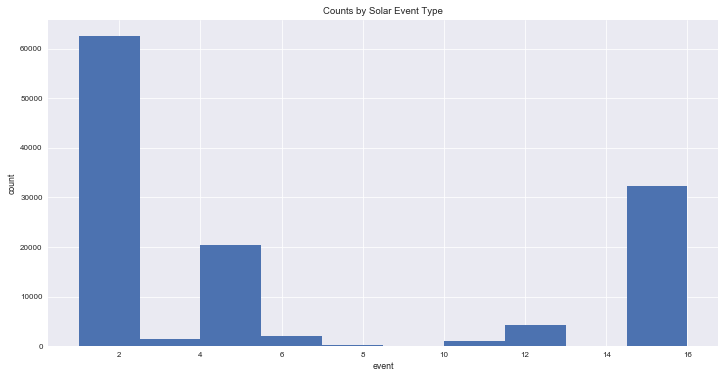

In [7]:
plt.figure(figsize=(12,6))
plt.hist(df.type);
plt.title('Counts by Solar Event Type')
plt.xlabel('event')
plt.ylabel('count')
plt.show()

> There is 2 main clusters. One centered around 2 and the other surrounded around 15. 

| Number | Code  | Description | 
|:-------:|:------:|:------:|
| 1 | XRA | X-ray event from GOES |
| 2 | RSP | Sweep-frequency radio burst |
| 3 | RNS | Radio noise storm |
| 4 | FLA | Optical flare observed in H-alpha |
| 5 | EPL | Eruptive prominence on limb |
| 6 | DSF | Filament disappearence |
| 7 | LPS | Loop prominence system |
| 8 | SPY | Spray |
| 9 | BSL | Bright surge on the limb |
| 10 | NEV | No event |
| 11 | PRO | Prominence (not specified in NOAA readme) |
| 12 | XFL | X-ray flare from GOES |
| 13 | DSD | Solar flare - Dark Surge on Disk |
| 14 | CME | Coronal Mass Ejection (not specified in NOAA readme) |
| 15 | BSD | Unspecified |
| 16 | RBR | Fixed-frequency radio burst |

In [8]:
data = df.type

In [9]:
date.index = date.index.to_datetime()

/Users/aubreybrowne/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


In [10]:
date.head()

,Unnamed: 0,type,reg_num,yes_no,duration,del_begin_max,del_end_max,closer_begin_end,flare_event,datetime
2001-01-01,406,116,46430.0,29.0,357,87,243.0,3.0,4,2.837321e+10
2001-01-02,300,89,NaN,25.0,325,140,146.0,3.0,0,2.446124e+10
2001-01-03,1431,329,55746.0,54.0,651,108,285.0,9.0,3,5.284205e+10
2001-01-04,406,213,27879.0,29.0,95,30,46.0,4.0,3,2.838060e+10
2001-01-05,435,159,46510.0,30.0,247,84,144.0,4.0,4,2.936159e+10


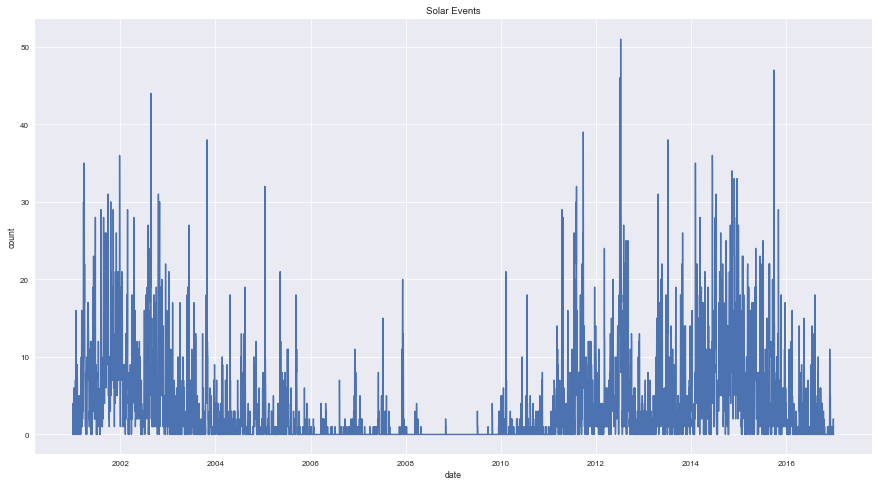

In [11]:
plt.figure(figsize=(15,8))
plt.plot(date.index, date.flare_event);
plt.title('Solar Events')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

In [12]:
#data = date.flare_event

In [13]:
k = 2
ndata = 124553

In [16]:
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0,0], sd=15, shape=k) #mu=[0,0,0]
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)) #+ tt.switch(means[2]-means[1] < 0, -np.inf, 0)

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [17]:
#Sampling 
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1])
    tr = pm.sample(10000, step=[step1, step2])

/Users/aubreybrowne/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
100%|██████████| 10000/10000 [5:42:58<00:00,  2.05s/it] 


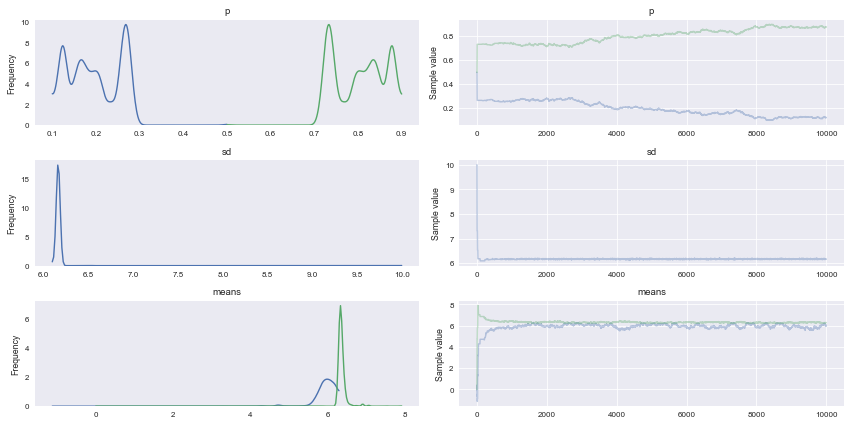

In [18]:
pm.plots.traceplot(tr, ['p', 'sd', 'means']);

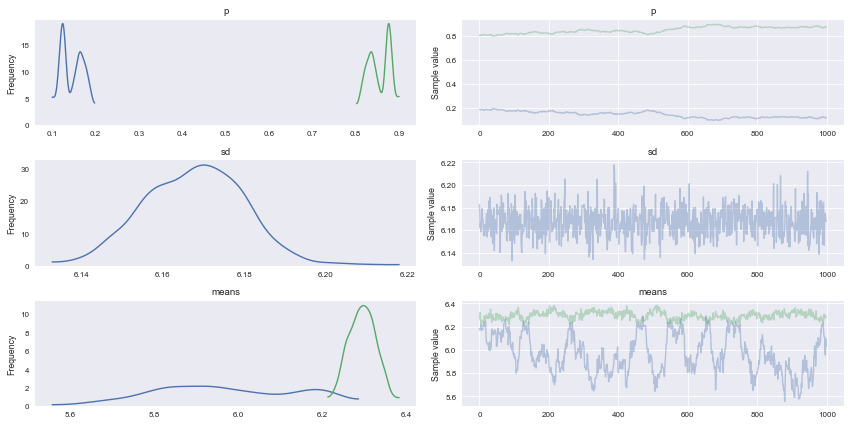

In [19]:
# After convergence
pm.plots.traceplot(tr[5000::5], ['p', 'sd', 'means']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1199423c8>]], dtype=object)

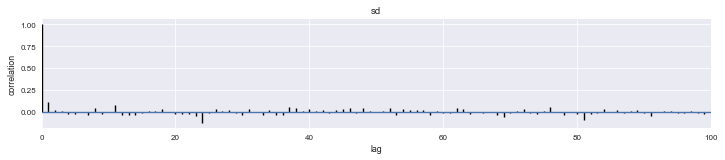

In [20]:
pm.autocorrplot(tr[5000::5], varnames=['sd'])

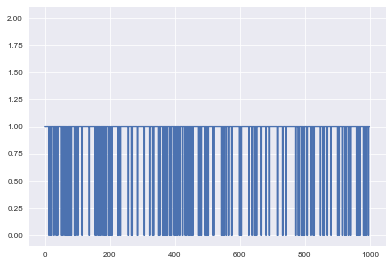

In [21]:
i=0
plt.plot(tr['category'][5000::5, i], drawstyle='steps-mid')
plt.axis(ymin=-.1, ymax=2.1)
plt.show()

true cluster: 2
  data value: 1


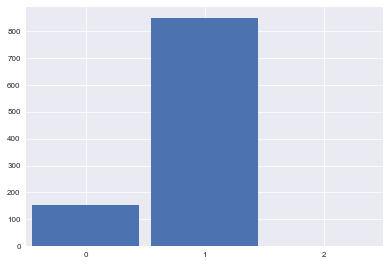

In [23]:
def cluster_posterior(i=0):
    print('true cluster:', v[i])
    print('  data value:', np.round(data[i],2))
    plt.hist(tr['category'][5000::5,i], bins=[-.5,.5,1.5,2.5,], rwidth=.9)
    plt.axis(xmin=-.5, xmax=2.5)
    plt.xticks([0,1,2])
cluster_posterior(i)